## Target : default payment next month (다음날 연체 여부, 1-연체/0-정상납부)

In [22]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel('CardClients.xls', sheet_name='Data')
print('dataset shape :',df.shape)
df.head(3)

dataset shape : (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


In [8]:
df.rename(columns={'PAY_0':'PAY_1','default payment next month':'default'}, inplace=True)
y_target = df['default']
X_features = df.drop('default', axis=1)

In [13]:
X_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 23 columns):
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_1        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
dtypes: int64(23)
memory usage: 5.3 MB


In [15]:
print(df['default'].value_counts())

0    23364
1     6636
Name: default, dtype: int64


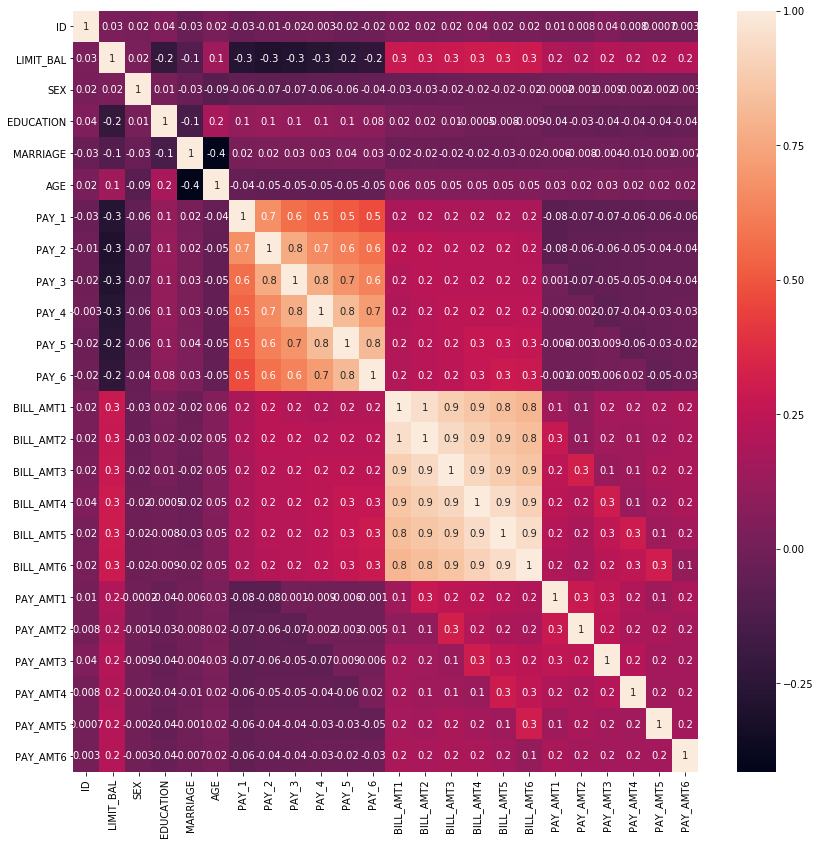

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

corr = X_features.corr()
plt.figure(figsize=(14,14))
sns.heatmap(corr, annot=True, fmt='.1g')

In [33]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rcf = RandomForestClassifier(n_estimators=300, random_state=156, n_jobs=-1)
scores = cross_val_score(rcf, X_features, y_target, scoring='accuracy', cv=3, n_jobs=-1 )

print('CV=3 인 경우의 개별 Fold세트별 정확도:',scores)
print('평균 정확도:{0:.4f}'.format(np.mean(scores)))

CV=3 인 경우의 개별 Fold세트별 정확도: [0.257  0.8208 0.784 ]
평균 정확도:0.6206


# PCA 

In [21]:
# BILL_AMT만 PCA 적용

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#BILL_AMT1 ~ BILL_AMT6 까지 6개의 속성명 생성
cols_bill = ['BILL_AMT'+str(i) for i in range(1,7)]
print('대상 속성명:',cols_bill)

# 2개의 PCA 속성을 가진 PCA 객체 생성하고, explained_variance_ratio_ 계산 위해 fit( ) 호출
scaler = StandardScaler()
df_cols_scaled = scaler.fit_transform(X_features[cols_bill])
pca = PCA(n_components=2)
pca.fit(df_cols_scaled)
print('PCA Component별 변동성 :',pca.explained_variance_ratio_)

대상 속성명: ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
PCA Component별 변동성 : [0.90555253 0.0509867 ]


In [29]:
# 전체 데이터에 PCA 적용
# 원본 데이터셋에 먼저 StandardScaler적용
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X_features)

# PCA 변환을 수행하고 cross_val_score( )로 분류 예측 수행. 
import tqdm
for i in tqdm.tqdm([6,12,18]) :
    pca = PCA(n_components=6)
    df_pca = pca.fit_transform(df_scaled)
    scores_pca = cross_val_score(rcf, df_pca, y_target, scoring='accuracy', cv=3)
    print('-'*15)
    print('n_components = ',i)
    print('CV=3, PCA 변환된 개별 Fold세트별 정확도:',scores_pca)
    print('PCA 변환 후 평균 정확도:{0:.4f}'.format(np.mean(scores_pca)))

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

---------------
n_components =  6
CV=3, PCA 변환된 개별 Fold세트별 정확도: [0.7779 0.7993 0.8031]
PCA 변환 후 평균 정확도:0.7934


 33%|████████████████████████████                                                        | 1/3 [01:22<02:44, 82.02s/it]

---------------
n_components =  12
CV=3, PCA 변환된 개별 Fold세트별 정확도: [0.7752 0.7991 0.8034]
PCA 변환 후 평균 정확도:0.7926


 67%|████████████████████████████████████████████████████████                            | 2/3 [02:38<01:20, 80.41s/it]

---------------
n_components =  18
CV=3, PCA 변환된 개별 Fold세트별 정확도: [0.7745 0.8001 0.8035]
PCA 변환 후 평균 정확도:0.7927


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:10<00:00, 83.84s/it]


## LDA

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=6)
lda.fit(df_scaled, y_target)
iris_lda = lda.transform(df_scaled)
scores_lda = cross_val_score(rcf, iris_lda, y_target, scoring='accuracy', cv=3 )
print('CV=3, LDA 변환된 개별 Fold세트별 정확도:',scores_lda)
print('LDA 변환 후 평균 정확도:{0:.4f}'.format(np.mean(scores_lda)))

CV=3, LDA 변환된 개별 Fold세트별 정확도: [0.7137 0.7162 0.7203]
LDA 변환 후 평균 정확도:0.7167


## SVM

In [35]:
from sklearn.decomposition import TruncatedSVD, PCA
tsvd = TruncatedSVD(n_components=6)
tsvd.fit(df)
iris_tsvd = tsvd.transform(df)
scores_svm = cross_val_score(rcf, iris_tsvd, y_target, scoring='accuracy', cv=3 )
print('CV=3, SVD 변환된 개별 Fold세트별 정확도:',scores_svm)
print('SVD 변환 후 평균 정확도:{0:.4f}'.format(np.mean(scores_svm)))

CV=3, SVD 변환된 개별 Fold세트별 정확도: [0.771  0.7804 0.7813]
SVD 변환 후 평균 정확도:0.7776


## NMF

In [36]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=2)
nmf.fit(df)
iris_nmf = nmf.transform(df)
scores_nmf = cross_val_score(rcf, iris_tsvd, y_target, scoring='accuracy', cv=3 )
print('CV=3, SVD 변환된 개별 Fold세트별 정확도:',scores_nmf)
print('SVD 변환 후 평균 정확도:{0:.4f}'.format(np.mean(scores_nmf)))

ValueError: Negative values in data passed to NMF (input X)